# **Dataset Load (GAN)**

**Train Dataset**
- Normal: 500
- Type1(FR50): 25(existing) + 475(generated)
- Type2(Fan): 25(existing) + 475(generated)

**Test Dataset**
- Normal: 100
- Type1(FR50): 100
- Type2(Fan): 100

아래 주석처리된 복제 데이터 경로를 본인 컴퓨터 환경에 맞추어서 재설정하시고, 잘 불러와지는지 확인하세요.  
train_set과 test_set 변수로 이미지가 각각 총 1500장, 300장으로 구성되어야합니다.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import os
from PIL import Image

def load_dataset_from_directory(root_dir):
    dataset = []
    class_names = sorted(os.listdir(root_dir))  # ['normal', 'type1', 'type2']

    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)

        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path).convert('RGB')
                    dataset.append((img, class_name))
                except:
                    print(f"Error loading image: {img_path}")

    return dataset

# '산업공학종합설계2' 폴더 이전의 데이터 경로를 컴퓨터 환경에 맞추어 바꾸어주세요!
### TO DO ###
train_root = "/gdrive/MyDrive/산업공학종합설계2/Datasets_GAN/train"
test_root = "/gdrive/MyDrive/산업공학종합설계2/Datasets_GAN/test"

# 데이터 로딩
train_set = load_dataset_from_directory(train_root)
test_set = load_dataset_from_directory(test_root)

print(f"Train set size : {len(train_set)}")
print(f"Test  set size : {len(test_set)}")

Train set size : 1500
Test  set size : 300


# **CNN Classifier with Oversampled/Generated Dataset**

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

# Define image transformations
# Using common mean and std for pre-trained models on ImageNet, resize to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dictionary to map string labels to numerical integers
label_mapping = {'normal': 0, 'type1': 1, 'type2': 2}

# Define a custom PyTorch Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None, label_map=None):
        self.data = data
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label_str = self.data[idx]
        if self.transform:
            img = self.transform(img)

        # Encode label to numerical integer
        label = self.label_map[label_str] if self.label_map else label_str
        label = torch.tensor(label, dtype=torch.long)

        return img, label

# Instantiate the custom Dataset class
train_dataset = CustomImageDataset(train_set, transform=transform, label_map=label_mapping)
test_dataset = CustomImageDataset(test_set, transform=transform, label_map=label_mapping)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

# 6Calculate class weights for the training data
train_labels = [label_mapping[label] for _, label in train_set]
class_counts = Counter(train_labels)

# 7. Create PyTorch DataLoader objects
batch_size = 32 # Can be adjusted

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train DataLoader batch size: {train_loader.batch_size}")
print(f"Test DataLoader batch size: {test_loader.batch_size}")

Train Dataset size: 1500
Test Dataset size: 300
Train DataLoader batch size: 32
Test DataLoader batch size: 32


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Input image size 224x224. After 3 pooling layers (each reduces size by factor of 2),
        # the feature map size will be 224 / (2*2*2) = 224 / 8 = 28.
        # So, 128 channels (from conv3) * 28 * 28 pixels = 100352 features
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply first convolutional block
        x = self.pool1(F.relu(self.conv1(x)))
        # Apply second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))
        # Apply third convolutional block (Restored)
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model with the updated architecture
model = CNN(num_classes=len(label_mapping))

# Print the model architecture
print("CNN Model Architecture (3 Convolutional Layers):")
print(model)

# Check if CUDA is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")

CNN Model Architecture (3 Convolutional Layers):
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)
Model moved to: cuda


# **Training**

In [ ]:
import torch.optim as optim

num_epochs = 15
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Number of epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Number of epochs: 15
Learning rate: 0.001
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Epoch 1/15, Loss: 0.7801
Epoch 2/15, Loss: 0.0611
Epoch 3/15, Loss: 0.0415
Epoch 4/15, Loss: 0.0322
Epoch 5/15, Loss: 0.0487
Epoch 6/15, Loss: 0.0430
Epoch 7/15, Loss: 0.0538
Epoch 8/15, Loss: 0.0328
Epoch 9/15, Loss: 0.0234
Epoch 10/15, Loss: 0.0129
Epoch 11/15, Loss: 0.0232
Epoch 12/15, Loss: 0.0203
Epoch 13/15, Loss: 0.0097
Epoch 14/15, Loss: 0.0035
Epoch 15/15, Loss: 0.0052
Training complete.


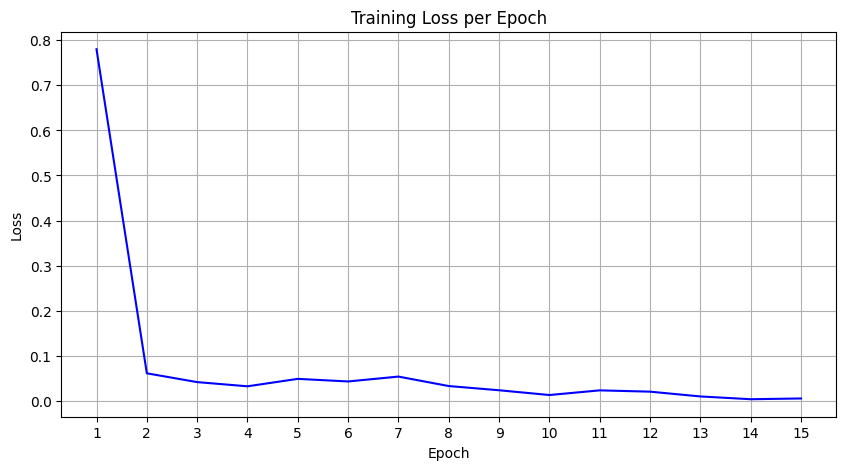

In [ ]:
import matplotlib.pyplot as plt

# List to store training losses per epoch
train_losses = []

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate average epoch loss
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()

# **Results and Visualization**


--- Classification Report ---
Weighted Precision: 0.9048
Weighted Recall: 0.8667
Weighted F1-score: 0.8611
Macro Precision: 0.9048
Macro Recall: 0.8667
Macro F1-score: 0.8611

Metrics per class:
  Class 'normal' (Label 0):
    Precision: 0.7143
    Recall: 1.0000
    F1-score: 0.8333
  Class 'type1' (Label 1):
    Precision: 1.0000
    Recall: 0.6000
    F1-score: 0.7500
  Class 'type2' (Label 2):
    Precision: 1.0000
    Recall: 1.0000
    F1-score: 1.0000


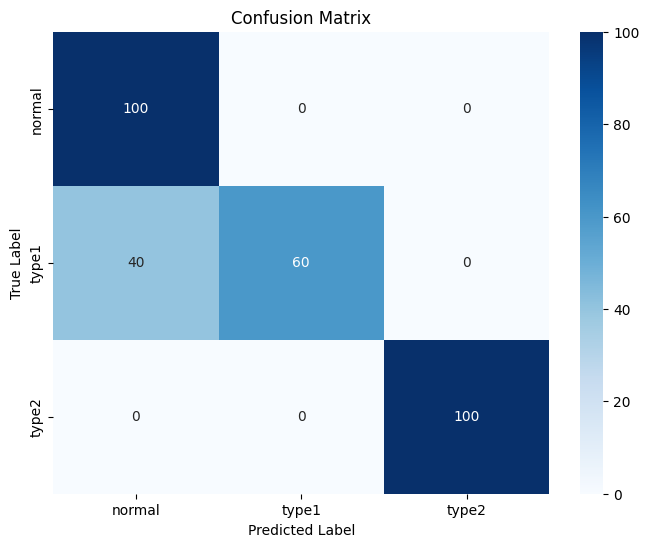

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# No gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and f1-score
# Using 'weighted' average to account for class imbalance
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', labels=np.unique(all_labels)
)

# Using 'macro' average to treat all classes equally
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', labels=np.unique(all_labels)
)

# Also calculate for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=np.unique(all_labels)
)

print("\n--- Classification Report ---")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")

class_names = list(label_mapping.keys())
print("\nMetrics per class:")
for i, class_name in enumerate(class_names):
    print(f"  Class '{class_name}' (Label {i}):")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall: {recall_per_class[i]:.4f}")
    print(f"    F1-score: {f1_per_class[i]:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.unique(all_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()